## Code blocks here were tested initially here and were moved to reinforcement_learning.py

In [1]:
import sys
import torch
import random
import timeit

# MCTS code imports
sys.path.append("..")  # Adds higher directory to python modules path.
from main import MeasurementControlEnvironment
from utils import rotate_about_point
from state_evaluation.reinforcement_learning import PolicyValueNetwork, ReplayMemory, MCTSRLWrapper, plot_state_image, get_image_based_state


### The following two blocks have been moved to state_evaluation/reinforcement_learning.py

In [2]:
# class PolicyValueNetwork(nn.Module):
#     """
#     Neural net combining policy and value network (state -> (policy, value))
#     params:
#         state_dims: Number of dimensions in the state space
#         action_dims: Number of dimensions in the action space
#     """
#     def __init__(self, state_dims, action_dims):
#         super(PolicyValueNetwork, self).__init__()
#         self.layer1 = nn.Linear(state_dims, 128)
#         self.layer2 = nn.Linear(128, 128)
#         self.layer3 = nn.Linear(128, action_dims+1) # +1 for the value output

#     # Called with either one element to determine next action, or a transitions
#     # during optimization. Returns tensor([[left0exp,right0exp]...]).
#     def forward(self, x):
#         x = F.relu(self.layer1(x))
#         x = F.relu(self.layer2(x))
#         return self.layer3(x)


# # Named tuple for transitions
# Transition = namedtuple('Transition',
#                         ('state', 'action', 'next_state', 'reward', 'done'))

# class ReplayMemory:
#     """
#     Replay memory for storing transitions
#     Creates a deque with a maximum length of capacity. Transitions are stored as named tuples.
    
#     methods:
#         push(*args): Save a transition
#         sample(batch_size): Sample a batch of transitions
#     """
#     def __init__(self, capacity):
#         self.memory = deque([], maxlen=capacity)

#     def push(self, *args):
#         """Save a transition"""
#         self.memory.append(Transition(*args))

#     def sample(self, batch_size):
#         return random.sample(self.memory, batch_size)

#     def __len__(self):
#         return len(self.memory)

# class MCTSRLWrapper:
#     def __init__(self, q_network: PolicyValueNetwork, target_q_network: PolicyValueNetwork,
#                  replay_memory: ReplayMemory, gamma: float=0.99, batch_size: int=64, 
#                  lr: float=0.001, tau: float=0.005):
#         self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         print("Using device:", self.device)
        
#         self.q_network = q_network.to(self.device) # Q Network which is trained on batches
#         self.target_q_network = target_q_network.to(self.device) # Q network used as target generator (very slowly updated for stability)
#         self.replay_memory = replay_memory # Replay memory for storing transitions
#         self.gamma = gamma # Discount factor
#         self.batch_size = batch_size # Number of transitions to sample for training
#         self.tau = tau # Soft update parameter for target network (target = tau * q_network + (1 - tau) * target_q_network)
#         self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr, amsgrad=True) # Adam optimizer for training the Q network
        
#     def loss(self, transitions):
#         """
#         Calculate the loss for a batch of transitions
#         """
#         # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
#         # detailed explanation). This converts batch-array of Transitions
#         # to Transition of batch-arrays.
#         transitions = Transition(*zip(*transitions))
        
#         # Pull out the components of the batch and concatinate them (concatenate scalar lists and stack tensor lists)
#         state_transitions = torch.stack(transitions.state)
#         action_transitions = torch.cat(transitions.action)
#         next_state_transitions = torch.stack(transitions.next_state)
#         reward_transitions = torch.cat(transitions.reward)
#         done_transitions = torch.cat(transitions.done)
        
#         # Get max Q target values of next state from target network (max_a' Q_target(s', a'))
#         max_next_q_value = self.target_q_network(next_state_transitions).max(dim=1).values
        
#         # Calculate the target (r + γ * max_a' Q_target(s', a')), what we want the Q network to predict
#         y_targets = reward_transitions + self.gamma * max_next_q_value * ~done_transitions # If done, the target is just the reward
        
#         # Get the current q_values, pick the values that are from the actions taken and then squeeze the tensor (remove the extra dimension)
#         q_values = self.q_network(state_transitions).gather(1, action_transitions).squeeze()

#         # Calculate the loss (difference between the target and the current q_value prediction)
#         loss = F.mse_loss(y_targets, q_values)
        
#         return loss
    
#     def optimize_model(self):
#         # Check if there are enough transitions in the replay memory to optimize
#         if len(self.replay_memory) < self.batch_size:
#             return
        
#         # Sample a batch of transitions
#         transitions = self.replay_memory.sample(self.batch_size)
        
#         # Set the network to training mode
#         self.q_network.train()
        
#         # Zero the gradients (reset the optimizer)
#         self.optimizer.zero_grad()
        
#         # Calculate the loss
#         loss = self.loss(transitions)
        
#         # Backpropagate the loss (calculate gradients for each parameter)
#         loss.backward()
        
#         # Perform a step of optimization (update the parameters of the q_network)
#         self.optimizer.step()

#         # Soft update of the target network
#         for target_param, param in zip(self.target_q_network.parameters(), self.q_network.parameters()):
#             target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)
    

In [3]:
# # Create state image from car position, OOI corners, car width, car_length and obstacles
# def get_image_based_state(env: MeasurementControlEnvironment, state: tuple, width_pixels=200, width_meters=50) -> tuple():
#     # Get car collision length and width
#     car_width, car_length = env.car.width, env.car.length
    
#     # Get obstacle means and radii
#     obstacle_means, obstacle_radii = env.eval_kd_tree.get_obstacle_points(), env.eval_kd_tree.get_obstacle_radii()

#     # Pull out the state components
#     car_state, corner_means, corner_covariance, horizon = state
#     corner_means = corner_means.reshape(-1, 2) # Reshape to 2D array where each row is a corner point
    
#     # Get normalized point covariances
#     pt_traces = env.get_normalized_cov_pt_traces(state)
    
#     # Since image is body frame representation of car, obstacles and OOIs. The neural net only needs [vx, delta, delta_dot] as input
#     # These are the components of the state which will determine how actions effect the car state, the rest of the state is used to generate the image
#     nn_car_state = car_state[[2, 4, 5]]
    
#     # Make the image
#     image = np.zeros((width_pixels, width_pixels), dtype=np.float32)
    
#     # Calculate the scaling factor from meters to pixels
#     scale = width_pixels / width_meters
    
#     # Rotate the obstacle and corner points to the car's yaw angle
#     car_pos, car_yaw = car_state[:2], car_state[3]
#     rotated_corners = rotate_about_point(corner_means, np.pi/2-car_yaw, car_pos) # Negative to rotate into a coordinate system where the car is facing up
#     rotated_obstacles = rotate_about_point(obstacle_means, np.pi/2-car_yaw, car_pos)
    
#     # Subtract the car's position from the rotated points to get the points relative to the car
#     rotated_corners -= car_state[:2]
#     rotated_obstacles -= car_state[:2]
    
#     # Find which points are within the image bounds
#     in_bounds_corners = (-width_meters/2 <= rotated_corners[:, 0]) & (rotated_corners[:, 0] <= width_meters/2) & \
#                         (-width_meters/2 <= rotated_corners[:, 1]) & (rotated_corners[:, 1] <= width_meters/2)

#     in_bounds_obstacles = (-width_meters/2 <= rotated_obstacles[:, 0]) & (rotated_obstacles[:, 0] <= width_meters/2) & \
#                           (-width_meters/2 <= rotated_obstacles[:, 1]) & (rotated_obstacles[:, 1] <= width_meters/2)

#     # Convert the car frame in bounds points to pixel coordinates
#     in_bounds_corner_pixels = (rotated_corners[in_bounds_corners] * scale + width_pixels / 2).astype(int)
#     in_bounds_obstacle_pixels = (rotated_obstacles[in_bounds_obstacles] * scale + width_pixels / 2).astype(int)
#     in_bounds_obstacle_radii_pixels = (obstacle_radii[in_bounds_obstacles] * scale).astype(int)
    
#     # First place obstacles so that rewards and car overlay them
#     for i, point in enumerate(in_bounds_obstacle_pixels):
#         x_pixel, y_pixel = point
#         radius_pixel = in_bounds_obstacle_radii_pixels[i]
#         x, y = np.ogrid[-x_pixel:width_pixels-x_pixel, -y_pixel:width_pixels-y_pixel]
#         mask = x*x + y*y <= radius_pixel*radius_pixel
#         image[mask] = -1.0
        
#     # Place the car (draw a rectangle at the center given length and width), car is always facing up (positive x axis)
#     car_width_pixels = int(car_width * scale)
#     car_length_pixels = int(car_length * scale)
#     car_max_x_index = car_width_pixels + width_pixels // 2
#     car_max_y_index = car_length_pixels + width_pixels // 2
#     image[-car_max_x_index:car_max_x_index, -car_max_y_index:car_max_y_index] = -0.5
    
#     # Place the corners
#     image[in_bounds_corner_pixels[:, 0], in_bounds_corner_pixels[:, 1]] = pt_traces[in_bounds_corners]
        
#     # Return the neural net state and the image
#     return nn_car_state, image

# def get_nn_state(env: MeasurementControlEnvironment, state: tuple, device: torch.device) -> torch.Tensor:
#     """
#     Convert full state into image and then combine car state and flattened image into a single tensor
#     params:
#         env: MeasurementControlEnvironment
#         state: Full state tuple
#         device: Device to put the tensor on
#     """
#     nn_car_state, image = get_image_based_state(env, state)
    
#     nn_state = torch.cat((torch.tensor(nn_car_state, dtype=torch.float32, device=device),
#                           torch.tensor(image.flatten(), dtype=torch.float32, device=device)))
    
#     return nn_state

# def plot_state_image(image, title):
#     plt.imshow(image.T, cmap='gray', origin='lower')
#     plt.colorbar(label='Value')
#     plt.title(title)
#     plt.show()

In [2]:
# Make a toy measurement control object (environment for MCTS)
env = MeasurementControlEnvironment(no_flask_server=True, enable_ui=False)

# Get the initial state sizes using the NN state space
nn_car_state, image = get_image_based_state(env, env.get_state())

# Get the observation (NN state space) length
num_actions = len(env.all_actions) # Number of actions (rows)

# Create the MCTSRL wrapper
mcts_rl = MCTSRLWrapper(env, 'new', num_actions, gamma=0.99, batch_size=10, lr=0.001, tau=0.005)

# Create some random transitions to test the loss function
state = env.get_state()
for i in range(10):
    # Pick a random action in the action space
    action = random.choice(env.all_actions)
    
    # Take the action and get the next state, reward, and done flag
    next_state, reward, done = env.step(state, action)
    
    # Save the transition
    mcts_rl.add_transition(state, action, next_state, reward, done)
    
    # Update the current state
    state = next_state
    
# Optimize the model
mcts_rl.optimize_model()
print("Optimization complete")

Toy Measurement Control Initialized
Using device: cuda
Model loaded
car state: [10.  0.  0.]
car state shape: (3,)
Car state tensor shape: torch.Size([3])
after unsqueeze: torch.Size([1, 200, 200])
car state: [10.          0.01634355  0.05447849]
car state shape: (3,)
Car state tensor shape: torch.Size([3])
after unsqueeze: torch.Size([1, 200, 200])
Add transition, image state shape: torch.Size([1, 200, 200])
car state: [10.          0.01634355  0.05447849]
car state shape: (3,)
Car state tensor shape: torch.Size([3])
after unsqueeze: torch.Size([1, 200, 200])
car state: [10.          0.04903064  0.10895697]
car state shape: (3,)
Car state tensor shape: torch.Size([3])
after unsqueeze: torch.Size([1, 200, 200])
Add transition, image state shape: torch.Size([1, 200, 200])
car state: [10.          0.04903064  0.10895697]
car state shape: (3,)
Car state tensor shape: torch.Size([3])
after unsqueeze: torch.Size([1, 200, 200])
car state: [10.          0.08171773  0.10895697]
car state shape

RuntimeError: Index tensor must have the same number of dimensions as input tensor

In [6]:
# Find inference time for the neural network
nn_car_state, nn_image_state = mcts_rl.get_nn_state(state)
start = timeit.default_timer()
mcts_rl.q_network(nn_car_state, nn_image_state)
end = timeit.default_timer()
print("Inference time:", end-start, "seconds")

# Print the number of parameters in the network
print("Number of parameters in Q Network:", sum(p.numel() for p in mcts_rl.q_network.parameters()))

# Inference time: 0.00032624600135022774 seconds
# Number of parameters in Q Network: 5140378

car state: [3.10391113 0.50846586 0.        ]
car state shape: (3,)
Car state tensor shape: torch.Size([3])
after unsqueeze: torch.Size([1, 200, 200])
Input image state shape: torch.Size([1, 200, 200])
After conv1: torch.Size([32, 200, 200])
After max pool: torch.Size([32, 100, 100])
After conv2: torch.Size([64, 100, 100])
After max pool: torch.Size([64, 50, 50])
Vector state shape: torch.Size([128])
Image state shape: torch.Size([64, 2500])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

car state: [10.  0.  0.]
car state shape: (3,)
Car state tensor shape: torch.Size([3])
after unsqueeze: torch.Size([1, 200, 200])
Time to get NN state: 0.0021623040001941263


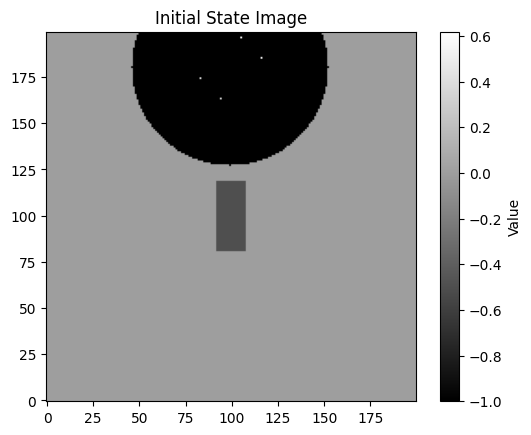

In [7]:
# grab a random state
state = env.get_state()
start_time = timeit.default_timer()
nn_car_state, nn_image_state = mcts_rl.get_nn_state(state)
print(f'Time to get NN state: {timeit.default_timer() - start_time}')

plot_state_image(image, 'Initial State Image')

In [ ]:
tuple_of_tensors = (torch.tensor([1, 2, 3], device=mcts_rl.device), torch.tensor([4, 5, 6], device=mcts_rl.device))
print(f'Tuple of tensors: {tuple_of_tensors}')
print(f'Concatenated tensors: {torch.stack(tuple_of_tensors).shape}')
tensor_stack = torch.stack(tuple_of_tensors)
tensor_stack.gather(1, torch.tensor([[2], [1]], device=mcts_rl.device)).squeeze()

Tuple of tensors: (tensor([1, 2, 3], device='cuda:0'), tensor([4, 5, 6], device='cuda:0'))
Concatenated tensors: torch.Size([2, 3])


tensor([3, 5], device='cuda:0')

In [ ]:
tuple_of_tensors = (torch.tensor([1], device=mcts_rl.device), torch.tensor([4], device=mcts_rl.device))
print(f'Tuple of tensors: {tuple_of_tensors}')
print(f'Concatenated tensors: {torch.cat(tuple_of_tensors).shape}')

Tuple of tensors: (tensor([1], device='cuda:0'), tensor([4], device='cuda:0'))
Concatenated tensors: torch.Size([2])


Convolutional Layer Weights:
Parameter containing:
tensor([[[[ 1.,  0., -1.],
          [ 1.,  0., -1.],
          [ 1.,  0., -1.]]]], requires_grad=True)

Input Image:
tensor([[[[0., 0., 0., 0., 0.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [0., 0., 0., 0., 0.]]]])

Output Feature Map after Convolution:
tensor([[[[-1.,  0.,  0.,  0.,  1.],
          [-2.,  0.,  0.,  0.,  2.],
          [-3.,  0.,  0.,  0.,  3.],
          [-2.,  0.,  0.,  0.,  2.],
          [-1.,  0.,  0.,  0.,  1.]]]], grad_fn=<ConvolutionBackward0>)


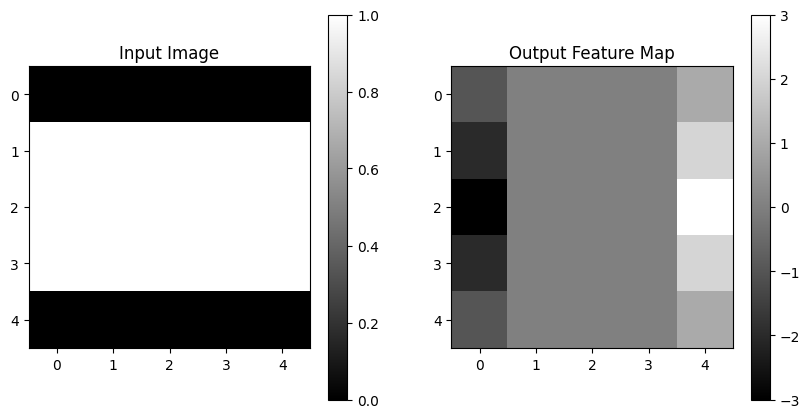

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Define a simple 2D convolutional layer
conv_layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1)

# Initialize the weights with specific values for better understanding (optional)
conv_layer.weight = nn.Parameter(torch.tensor([[[[1, 0, -1],
                                                 [1, 0, -1],
                                                 [1, 0, -1]]]], dtype=torch.float32))
conv_layer.bias = nn.Parameter(torch.tensor([0.0]))

# Print out the weights
print("Convolutional Layer Weights:")
print(conv_layer.weight)

# Create a simple 5x5 input image (e.g., a vertical edge)
input_image = torch.tensor([[[[0, 0, 0, 0, 0],
                              [1, 1, 1, 1, 1],
                              [1, 1, 1, 1, 1],
                              [1, 1, 1, 1, 1],
                              [0, 0, 0, 0, 0]]]], dtype=torch.float32)

# Pass the image through the convolutional layer
output = conv_layer(input_image)

# Print out the input and output
print("\nInput Image:")
print(input_image)

print("\nOutput Feature Map after Convolution:")
print(output)

# Visualize the input and output
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(input_image.squeeze(), cmap='gray')
plt.title("Input Image")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(output.detach().numpy().squeeze(), cmap='gray')
plt.title("Output Feature Map")
plt.colorbar()

plt.show()


In [ ]:
import torch
from torch.utils.data import DataLoader

# Assume `dataset` is your experience replay buffer or training data

def find_optimal_batch_size(model, dataset, init_batch_size=32, max_memory_utilization=0.9):
    batch_size = init_batch_size
    while True:
        try:
            # Create a DataLoader with the current batch size
            data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
            # Run a forward pass to check memory usage
            for batch in data_loader:
                inputs = batch['input'].to('cuda')
                outputs = model(inputs)
                loss = some_loss_function(outputs, batch['target'])
                loss.backward()
                # Check GPU memory usage
                memory_allocated = torch.cuda.memory_allocated()
                total_memory = torch.cuda.get_device_properties(0).total_memory
                utilization = memory_allocated / total_memory
                if utilization > max_memory_utilization:
                    print(f"Memory utilization {utilization:.2f}, reducing batch size")
                    batch_size //= 2
                    return batch_size
            # If memory usage is fine, increase batch size
            print(f"Batch size {batch_size} fits in memory, doubling batch size")
            batch_size *= 2
        except RuntimeError as e:
            if 'out of memory' in str(e):
                print("OOM Error, reducing batch size")
                batch_size //= 2
                return batch_size
            else:
                raise e

# Example usage
optimal_batch_size = find_optimal_batch_size(your_model, your_dataset)
print(f"Optimal batch size: {optimal_batch_size}")


NameError: name 'your_model' is not defined